<img src='pics/otus.png'>

In [1]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

# Кластеризация - кейс

# Данные

https://www.kaggle.com/carrie1/ecommerce-data

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

In [2]:
df = pd.read_csv('data.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [4]:
# Дубликаты
df.duplicated().sum()

5268

In [5]:
df.drop_duplicates(inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      536641 non-null object
StockCode      536641 non-null object
Description    535187 non-null object
Quantity       536641 non-null int64
InvoiceDate    536641 non-null datetime64[ns]
UnitPrice      536641 non-null float64
CustomerID     401604 non-null float64
Country        536641 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.8+ MB


**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  
**Description**: Product (item) name. Nominal.  
**Quantity**: The quantities of each product (item) per transaction. Numeric.  
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.   
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling.  
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  
**Country**: Country name. Nominal, the name of the country where each customer resides.  



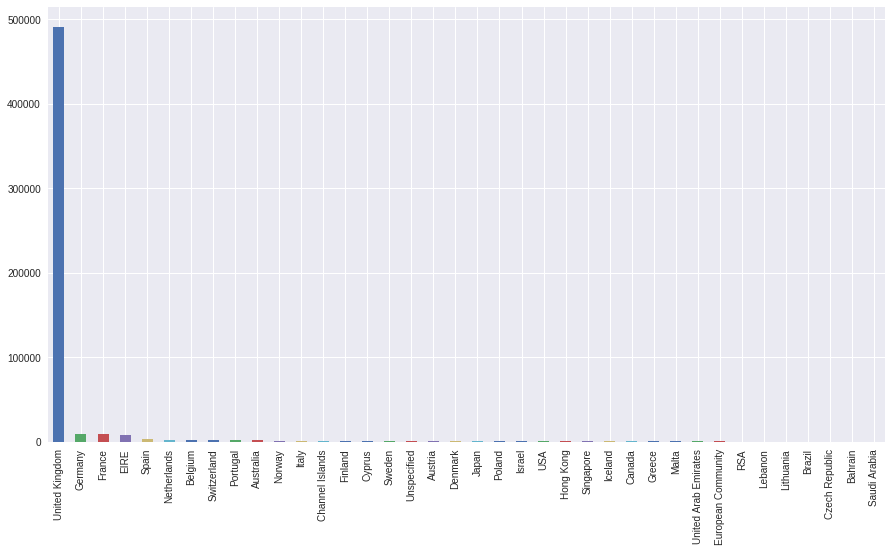

In [7]:
df.Country.value_counts().plot.bar()

In [8]:
# покупатели
df.CustomerID.unique().shape

(4373,)

In [9]:
# Заказы
df.InvoiceNo.unique().shape

(25900,)

In [10]:
# Продукты
df.StockCode.unique().shape

(4070,)

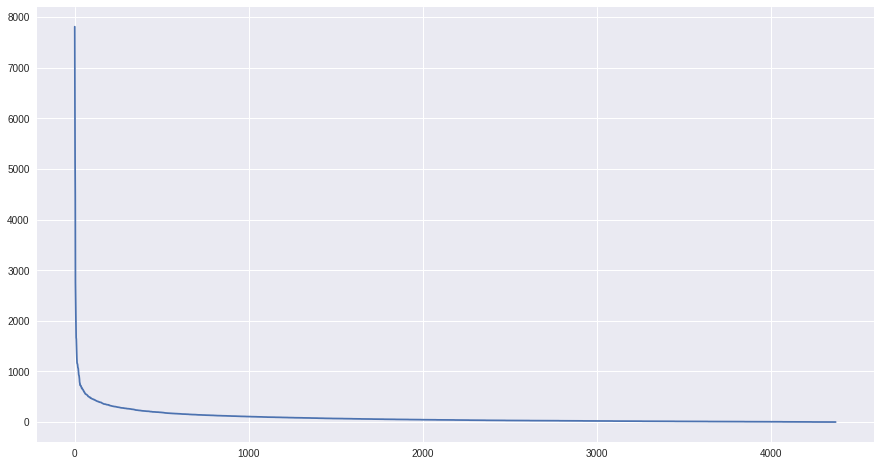

In [11]:
# Сколько заказов сделали пользователи?
counts_df = df[['CustomerID', 'InvoiceNo']].groupby('CustomerID').agg('count').sort_values(by=['InvoiceNo'], ascending=False)
counts = counts_df.as_matrix()
plt.plot(counts)

In [12]:
df[df['CustomerID'] == 12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.00,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.00,United Kingdom


In [13]:
counts_df.describe()

,InvoiceNo
count,4372.00
mean,91.86
std,229.22
min,1.00
25%,17.00
50%,41.00
75%,99.25
max,7812.00


In [14]:
np.where(counts == 1)[0].shape

(79,)

In [15]:
del counts
del counts_df

# Продукты

In [16]:
import re

letters = re.compile(r'[^A-Z ]+')
spaces = re.compile('  +')

def tokenize(row):
    row = letters.sub('', row)
    row = spaces.sub(' ', row)
    return row

print(tokenize('PAPER CRAFT , LITTLE BIRDIE'))
print(tokenize('????damages????'))
print(tokenize('CREAM HANGING HEART T-LIGHT HOLDER'))

PAPER CRAFT LITTLE BIRDIE

CREAM HANGING HEART TLIGHT HOLDER


In [17]:
df['DescriptionCleaned'] = df['Description'].replace(np.nan, '').apply(tokenize)

In [18]:
from collections import Counter
docs = []
word_count = Counter()
descs_unique = pd.DataFrame(df['DescriptionCleaned'].unique(), columns=['DescriptionCleaned'])
for idx, row in descs_unique.iterrows():
    desc = row['DescriptionCleaned']
    tokens = desc.split(' ')
    docs.append(Counter(tokens))
    for t in tokens:
        word_count[t] += 1

In [19]:
docs[:20]

[Counter({'HANGING': 1, 'HEART': 1, 'HOLDER': 1, 'TLIGHT': 1, 'WHITE': 1}),
 Counter({'LANTERN': 1, 'METAL': 1, 'WHITE': 1}),
 Counter({'COAT': 1, 'CREAM': 1, 'CUPID': 1, 'HANGER': 1, 'HEARTS': 1}),
 Counter({'BOTTLE': 1,
          'FLAG': 1,
          'HOT': 1,
          'KNITTED': 1,
          'UNION': 1,
          'WATER': 1}),
 Counter({'HEART': 1, 'HOTTIE': 1, 'RED': 1, 'WHITE': 1, 'WOOLLY': 1}),
 Counter({'BABUSHKA': 1, 'BOXES': 1, 'NESTING': 1, 'SET': 1}),
 Counter({'FROSTED': 1, 'GLASS': 1, 'HOLDER': 1, 'STAR': 1, 'TLIGHT': 1}),
 Counter({'HAND': 1, 'JACK': 1, 'UNION': 1, 'WARMER': 1}),
 Counter({'DOT': 1, 'HAND': 1, 'POLKA': 1, 'RED': 1, 'WARMER': 1}),
 Counter({'ASSORTED': 1, 'BIRD': 1, 'COLOUR': 1, 'ORNAMENT': 1}),
 Counter({'': 1, 'BEDROOM': 1, 'PLAYHOUSE': 1, 'POPPYS': 1}),
 Counter({'KITCHEN': 1, 'PLAYHOUSE': 1, 'POPPYS': 1}),
 Counter({'CHARLOTTE': 1, 'DOLL': 1, 'FELTCRAFT': 1, 'PRINCESS': 1}),
 Counter({'': 1, 'COSY': 1, 'IVORY': 1, 'KNITTED': 1, 'MUG': 1}),
 Counter({'

In [20]:
words_most = dict(word_count.most_common(300))
words_most

{'': 919,
 'A': 19,
 'ACRYLIC': 20,
 'ALPHABET': 15,
 'AMBER': 13,
 'AND': 80,
 'ANT': 12,
 'ANTIQUE': 40,
 'APPLES': 13,
 'APRON': 14,
 'ART': 75,
 'ASSORTED': 59,
 'BABUSHKA': 23,
 'BAG': 168,
 'BAKING': 16,
 'BALL': 16,
 'BAROQUE': 25,
 'BASKET': 22,
 'BATHROOM': 15,
 'BEAD': 38,
 'BEADED': 15,
 'BEADS': 19,
 'BELL': 24,
 'BELLS': 16,
 'BIRD': 45,
 'BIRTHDAY': 31,
 'BLACK': 97,
 'BLING': 25,
 'BLOSSOM': 14,
 'BLUE': 205,
 'BOOK': 23,
 'BOTANICAL': 16,
 'BOTTLE': 41,
 'BOUDICCA': 12,
 'BOWL': 53,
 'BOX': 136,
 'BOXES': 19,
 'BRACELET': 68,
 'BROWN': 13,
 'BUNNY': 23,
 'BUNTING': 19,
 'BUTTERFLY': 39,
 'CABINET': 23,
 'CAKE': 82,
 'CAN': 13,
 'CANDLE': 92,
 'CANDLES': 41,
 'CANDY': 15,
 'CARD': 86,
 'CARDS': 52,
 'CASES': 27,
 'CAT': 21,
 'CERAMIC': 45,
 'CHARLOTTE': 11,
 'CHARM': 39,
 'CHERRY': 15,
 'CHICK': 16,
 'CHILDRENS': 30,
 'CHILDS': 14,
 'CHOCOLATE': 26,
 'CHRISTMAS': 153,
 'CHUNKY': 13,
 'CIRCUS': 12,
 'CLASSIC': 19,
 'CLOCK': 44,
 'CM': 17,
 'COFFEE': 21,
 'COLOUR': 33,
 'C

In [21]:
docs_filtered = [{k: v for k, v in d.iteritems() if k in words_most} for d in docs]

In [22]:
docs_filtered

[{'HANGING': 1, 'HEART': 1, 'HOLDER': 1, 'TLIGHT': 1, 'WHITE': 1},
 {'LANTERN': 1, 'METAL': 1, 'WHITE': 1},
 {'CREAM': 1, 'HANGER': 1, 'HEARTS': 1},
 {'BOTTLE': 1, 'HOT': 1, 'UNION': 1, 'WATER': 1},
 {'HEART': 1, 'RED': 1, 'WHITE': 1},
 {'BABUSHKA': 1, 'BOXES': 1, 'SET': 1},
 {'GLASS': 1, 'HOLDER': 1, 'STAR': 1, 'TLIGHT': 1},
 {'HAND': 1, 'JACK': 1, 'UNION': 1, 'WARMER': 1},
 {'HAND': 1, 'RED': 1, 'WARMER': 1},
 {'ASSORTED': 1, 'BIRD': 1, 'COLOUR': 1},
 {'': 1},
 {'KITCHEN': 1},
 {'CHARLOTTE': 1, 'FELTCRAFT': 1},
 {'': 1, 'COSY': 1, 'IVORY': 1, 'MUG': 1},
 {'ASSORTED': 1, 'BOX': 1, 'COLOUR': 1, 'OF': 1},
 {'': 1, 'BOX': 1, 'JIGSAW': 1, 'OF': 1, 'VINTAGE': 1},
 {'ALPHABET': 1, 'BOX': 1, 'OF': 1, 'VINTAGE': 1},
 {'HOME': 1},
 {'LOVE': 1},
 {'BOX': 1, 'HEART': 1, 'METAL': 1, 'WITH': 1},
 {'DOORMAT': 1, 'NEW': 1},
 {'JAM': 1, 'SET': 1, 'WITH': 1},
 {'RACK': 1, 'RED': 1},
 {'RACK': 1, 'YELLOW': 1},
 {'BLUE': 1, 'RACK': 1},
 {},
 {'CLOCK': 1, 'PINK': 1},
 {'': 1, 'CLOCK': 1, 'RED': 1},
 {'CL

In [23]:
from sklearn.feature_extraction import DictVectorizer

v = DictVectorizer(sparse=False)
X = v.fit_transform(docs_filtered)

In [24]:
X.shape

(3999, 300)

In [25]:
np.count_nonzero(X)

12453

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples


In [27]:

inertias = []
silhs = []
for n_clusters in range(3, 15):
    
    print(n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)
    
    print("For n_clusters =", n_clusters, "The inertia_ is :", kmeans.inertia_, "The average silhouette_score is :", silhouette_avg)
    
    inertias.append(kmeans.inertia_)
    silhs.append(silhouette_avg)
    


3
For n_clusters = 3 The inertia_ is : 11064.9250839 The average silhouette_score is : 0.0857210564694
4
For n_clusters = 4 The inertia_ is : 10972.5891817 The average silhouette_score is : 0.0754718815416
5
For n_clusters = 5 The inertia_ is : 10735.666254 The average silhouette_score is : 0.0823854852313
6
For n_clusters = 6 The inertia_ is : 10553.487187 The average silhouette_score is : 0.0904431797523
7
For n_clusters = 7 The inertia_ is : 10470.5623244 The average silhouette_score is : 0.071561742923
8
For n_clusters = 8 The inertia_ is : 10334.640328 The average silhouette_score is : 0.08038734178
9
For n_clusters = 9 The inertia_ is : 10226.3930212 The average silhouette_score is : 0.0658579711581
10
For n_clusters = 10 The inertia_ is : 10194.3918611 The average silhouette_score is : 0.0709510103192
11
For n_clusters = 11 The inertia_ is : 10055.8118501 The average silhouette_score is : 0.0855492576203
12
For n_clusters = 12 The inertia_ is : 9982.49326669 The average silhouet

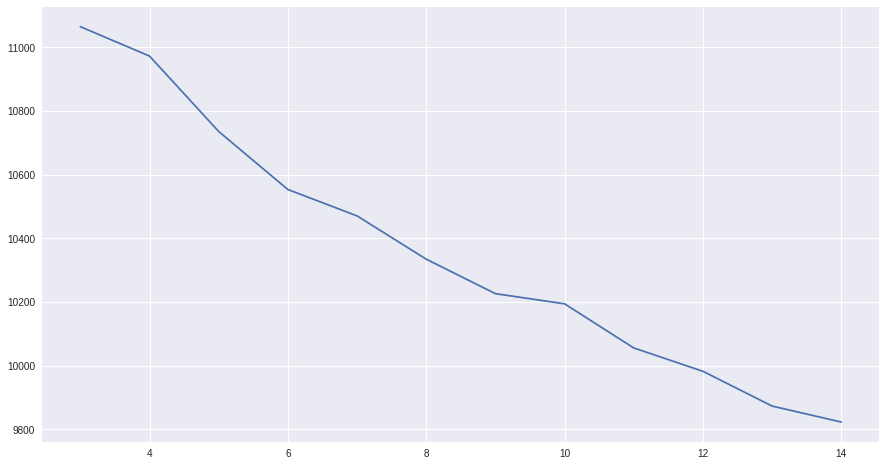

In [28]:
plt.plot(range(3, 15), inertias)

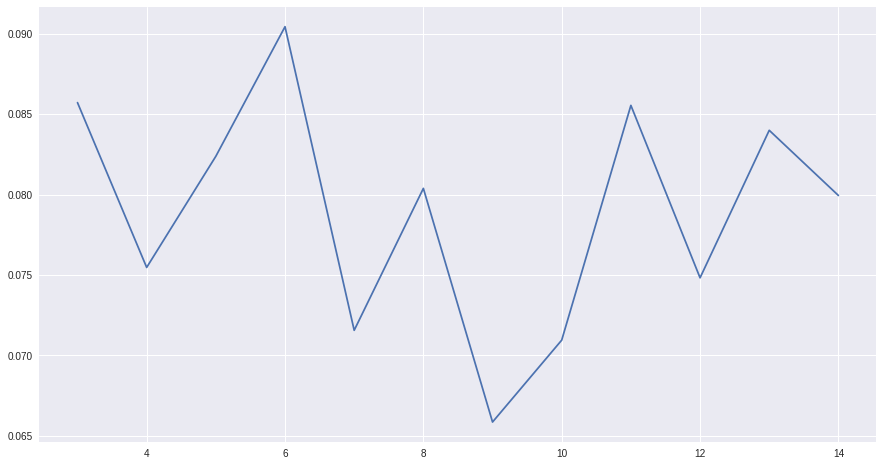

In [29]:
plt.plot(range(3, 15), silhs)

In [30]:
def clusters_stats(n_clusters, clusters, print_words=True):
    fig, ax1 = plt.subplots(1, 1)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    silhouette_avg = silhouette_score(X, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, clusters)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    
    print(np.bincount(clusters))
    if print_words:
        cluster_words_count = defaultdict(Counter)

        for c, doc in zip(clusters, docs_filtered):
            for w in doc.keys():
                cluster_words_count[c][w] += 1

        for c in cluster_words_count:
            print('Cluster {}'.format(c))
            print(', '.join('{}: {}'.format(w, count) for w, count in cluster_words_count[c].most_common(10)))
            print()

For n_clusters = 11 The average silhouette_score is : 0.0793124977308


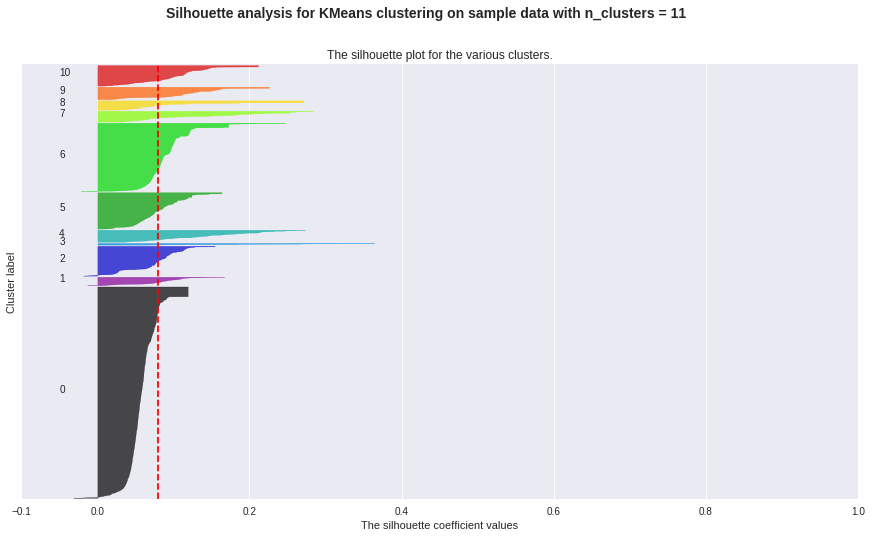

[2002   82  283   18  114  346  648  103   89  119  195]
Cluster 0
RED: 119, HEART: 118, VINTAGE: 115, GLASS: 108, BAG: 91, NECKLACE: 85, CHRISTMAS: 83, WHITE: 81, BOX: 78, GREEN: 71

Cluster 1
HANGING: 82, DECORATION: 21, HEART: 20, : 11, FLOWER: 8, FELT: 8, CAKE: 7, WITH: 6, CHRISTMAS: 6, IVORY: 6

Cluster 2
PINK: 283, : 47, HEART: 22, POLKADOT: 21, FLOWER: 15, BAG: 15, VINTAGE: 12, COVER: 12, FLOCK: 12, GLASS: 12

Cluster 3
OF: 17, SET: 15, DOILIES: 14, PAPER: 14, SKULL: 4, PACK: 3, VINTAGE: 2, PANTRY: 2, SPACEBOY: 2, DESIGN: 2

Cluster 4
HOLDER: 110, TLIGHT: 77, HEART: 21, HANGING: 17, GLASS: 15, ZINC: 11, CANDLE: 11, SILVER: 11, STAR: 9, : 7

Cluster 5
SET: 346, OF: 130, : 113, CARDS: 37, VINTAGE: 24, TINS: 19, TLIGHTS: 17, PAPER: 16, CUTLERY: 15, CANDLES: 15

Cluster 6
: 648, RED: 51, VINTAGE: 45, CHRISTMAS: 39, HEART: 29, LARGE: 28, BAG: 26, METAL: 25, BOX: 24, WHITE: 24

Cluster 7
WALL: 86, ART: 68, : 33, CLOCK: 14, MIRRORED: 11, HEART: 8, AND: 8, FLOWER: 7, WHITE: 6, DOG: 5

C

In [31]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
kmeans.fit(X)
clusters = kmeans.predict(X)
kmeans.inertia_
clusters_stats(n_clusters, clusters)

For n_clusters = 7 The average silhouette_score is : 0.0814726268191


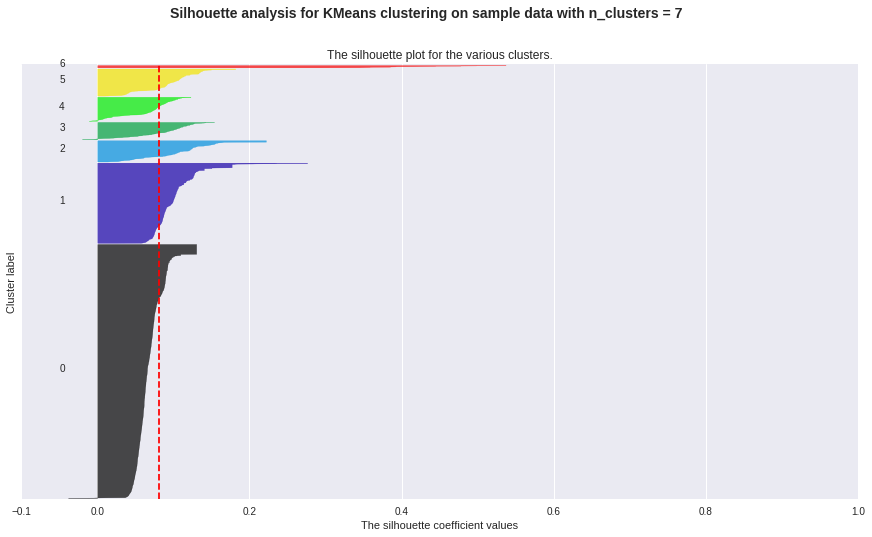

[2381  753  200  162  226  255   22]
Cluster 0
SET: 228, OF: 166, VINTAGE: 123, RED: 116, GLASS: 114, BOX: 90, CHRISTMAS: 86, NECKLACE: 85, DESIGN: 83, HOLDER: 81

Cluster 1
: 753, SET: 113, OF: 50, RED: 49, CARDS: 44, CHRISTMAS: 41, VINTAGE: 39, WALL: 33, RETROSPOT: 27, ART: 27

Cluster 2
BLUE: 200, : 30, POLKADOT: 20, FLOWER: 12, HEART: 11, GARDEN: 9, EGG: 8, SIGN: 8, FRENCH: 8, METAL: 8

Cluster 3
BAG: 162, VINTAGE: 30, : 29, JUMBO: 26, CHARM: 18, DESIGN: 18, RED: 17, GIFT: 17, LUNCH: 17, PAISLEY: 13

Cluster 4
HEART: 226, : 37, DECORATION: 27, PINK: 24, HANGING: 23, HOLDER: 22, LOVE: 20, TLIGHT: 18, SMALL: 18, LARGE: 17

Cluster 5
PINK: 255, : 47, POLKADOT: 18, FLOWER: 16, COVER: 12, FLOCK: 12, BUTTERFLY: 10, CUSHION: 9, GLASS: 9, SET: 9

Cluster 6
HOME: 22, SWEET: 21, : 8, DOORMAT: 3, HOLDER: 2, HANGER: 2, OF: 2, STORAGE: 1, HOOK: 1, TIN: 1



In [32]:
n_clusters = 7
kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
kmeans.fit(X)
clusters = kmeans.predict(X)
kmeans.inertia_
clusters_stats(n_clusters, clusters)

In [33]:
descs_unique.shape, clusters.shape

((3999, 1), (3999,))

In [34]:
descs_unique['cluster'] = clusters

In [35]:
descs_unique.head()

,DescriptionCleaned,cluster
0,WHITE HANGING HEART TLIGHT HOLDER,4
1,WHITE METAL LANTERN,0
2,CREAM CUPID HEARTS COAT HANGER,0
3,KNITTED UNION FLAG HOT WATER BOTTLE,0
4,RED WOOLLY HOTTIE WHITE HEART,4


In [36]:
df = pd.merge(df, descs_unique, on='DescriptionCleaned', how='left')

In [37]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DescriptionCleaned,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,WHITE HANGING HEART TLIGHT HOLDER,4
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,WHITE METAL LANTERN,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,CREAM CUPID HEARTS COAT HANGER,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,RED WOOLLY HOTTIE WHITE HEART,4


In [41]:
df_clusters = df.cluster.as_matrix()
total_price = df.UnitPrice.as_matrix() * df.Quantity.as_matrix()

In [51]:
def get_cluster_total_spent(x, i):
    if x.cluster != i:
        return 0
    
    return x.UnitPrice * x.Quantity

for i in range(n_clusters):
    clusters_i = np.zeros(df_clusters.shape[0])
    clusters_i[df_clusters == i] = total_price[df_clusters == i]
    df['cluster_{}'.format(i)] = clusters_i

In [56]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,DescriptionCleaned,cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,WHITE HANGING HEART TLIGHT HOLDER,4,0.00,0.00,0.00,0.00,15.30,0.00,0.00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,WHITE METAL LANTERN,0,20.34,0.00,0.00,0.00,0.00,0.00,0.00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.00,0.00,0.00,0.00,0.00,0.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34,0.00,0.00,0.00,0.00,0.00,0.00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,RED WOOLLY HOTTIE WHITE HEART,4,0.00,0.00,0.00,0.00,20.34,0.00,0.00


In [53]:
group = df[['CustomerID', 'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6']].groupby('CustomerID').agg('sum')
group.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
CustomerID,,,,,,,
12346.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
12347.00,2410.36,920.50,57.90,459.70,183.54,278.00,0.00
12348.00,737.96,884.32,41.76,0.00,69.60,63.60,0.00
12349.00,1152.25,417.65,0.00,13.20,154.65,19.80,0.00
12350.00,156.20,117.60,40.20,20.40,0.00,0.00,0.00


In [57]:
customers = group[(group.cluster_0 != 0) | (group.cluster_1 != 0) | (group.cluster_2 != 0) | (group.cluster_3 != 0) | (group.cluster_4 != 0) | (group.cluster_5 != 0)| (group.cluster_6 != 0)]
customers.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
CustomerID,,,,,,,
12347.00,2410.36,920.50,57.90,459.70,183.54,278.00,0.00
12348.00,737.96,884.32,41.76,0.00,69.60,63.60,0.00
12349.00,1152.25,417.65,0.00,13.20,154.65,19.80,0.00
12350.00,156.20,117.60,40.20,20.40,0.00,0.00,0.00
12352.00,1053.81,262.15,32.40,0.00,93.80,103.25,0.00


In [58]:
X = customers.as_matrix()

In [59]:
X.shape

(4366, 7)

In [60]:
list(X.sum(axis=0))

[4723211.7139999997,
 1563658.8,
 182025.01000000001,
 859322.82000000007,
 619522.04999999993,
 251332.67999999999,
 79446.350000000006]

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
print('variables mean values: ', scaler.mean_)
scaled_matrix = scaler.transform(X)

variables mean values:  [ 1081.81670041   358.14448007    41.69148191   196.82153459   141.89694228
    57.56589098    18.19659872]


In [62]:

inertias = []
silhs = []
c_range = range(10, 30)
for n_clusters in c_range:
    
    print(n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    
    print("For n_clusters =", n_clusters, "The inertia_ is :", kmeans.inertia_, "The average silhouette_score is :", silhouette_avg)
    
    inertias.append(kmeans.inertia_)
    silhs.append(silhouette_avg)
    


10
For n_clusters = 10 The inertia_ is : 3243.90859423 The average silhouette_score is : 0.736366397379
11
For n_clusters = 11 The inertia_ is : 2919.47226234 The average silhouette_score is : 0.73661024023
12
For n_clusters = 12 The inertia_ is : 2683.91449854 The average silhouette_score is : 0.738480980357
13
For n_clusters = 13 The inertia_ is : 2460.21388645 The average silhouette_score is : 0.627280913846
14
For n_clusters = 14 The inertia_ is : 2302.79674373 The average silhouette_score is : 0.627496741716
15
For n_clusters = 15 The inertia_ is : 2158.11299808 The average silhouette_score is : 0.619520345735
16
For n_clusters = 16 The inertia_ is : 2017.35097007 The average silhouette_score is : 0.553551413163
17
For n_clusters = 17 The inertia_ is : 1916.24463246 The average silhouette_score is : 0.554015163585
18
For n_clusters = 18 The inertia_ is : 1828.41173487 The average silhouette_score is : 0.566501566012
19
For n_clusters = 19 The inertia_ is : 1749.73551234 The averag

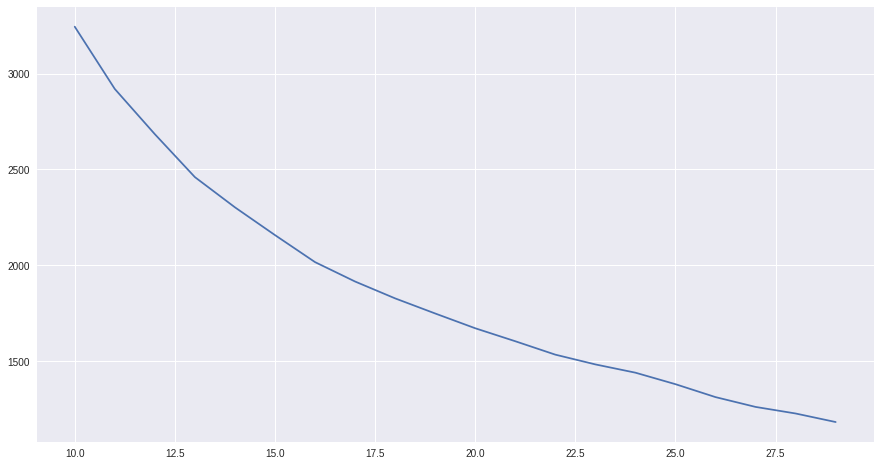

In [63]:
c_range = range(10, 30)
plt.plot(c_range, inertias)

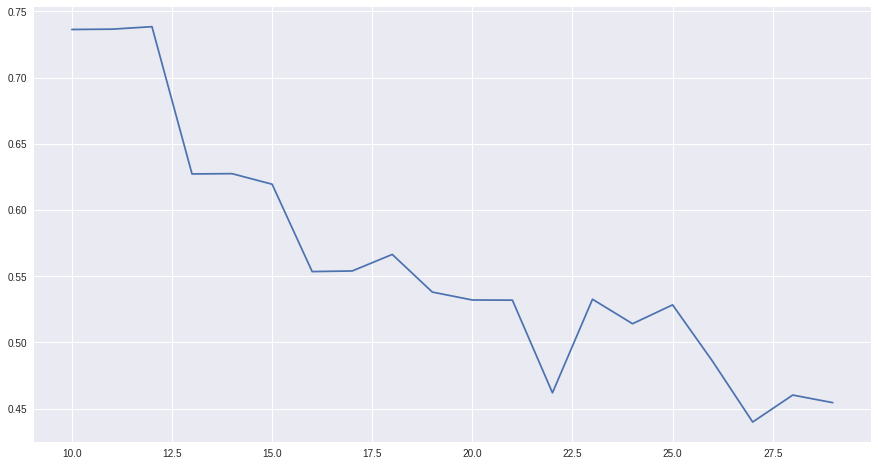

In [64]:
plt.plot(c_range, silhs)

For n_clusters = 20 The average silhouette_score is : 0.555637159077


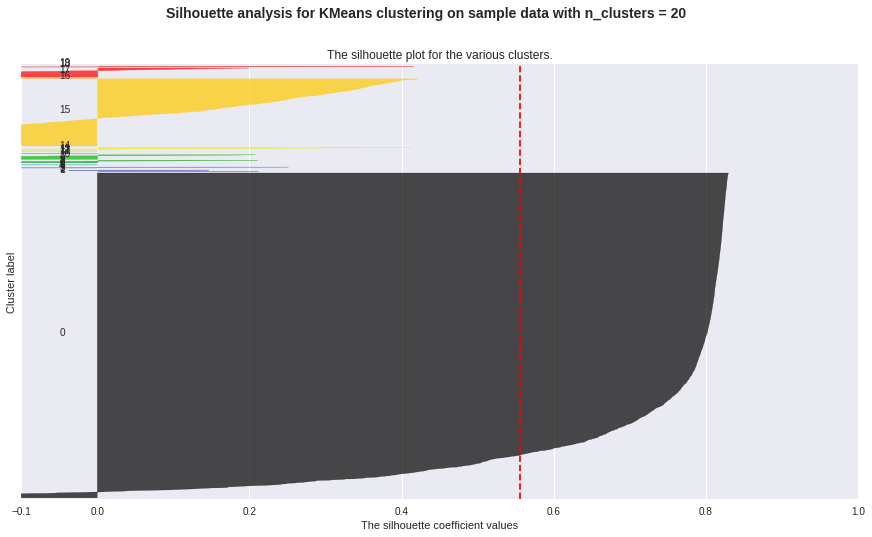

[3419    1    2    3    1   11    1    2    1   26   49    3    1    3   30
  707    3   96    6    1]
For n_clusters = 21 The average silhouette_score is : 0.46466515336


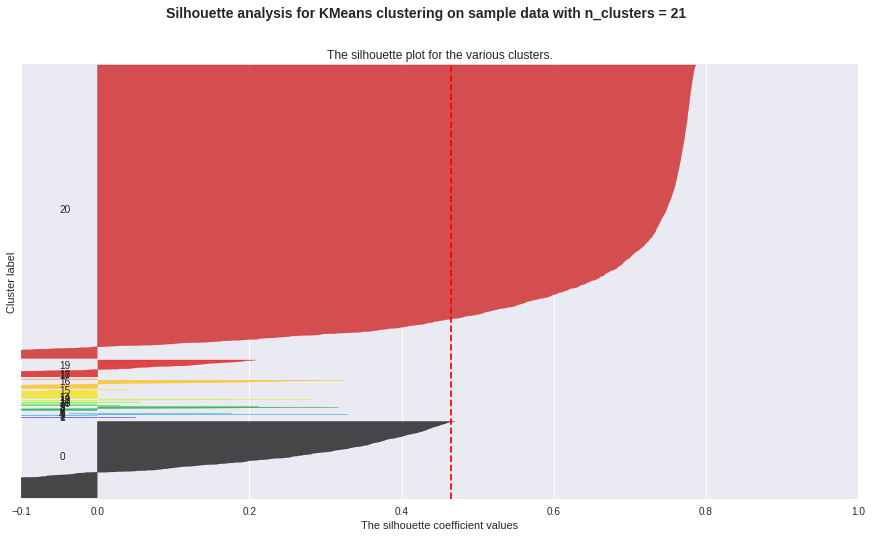

[ 807    1    1    1    4    1   12    3    1   37    2    3    2   11   19
   93   89    3    1  179 3096]
For n_clusters = 22 The average silhouette_score is : 0.524992071322


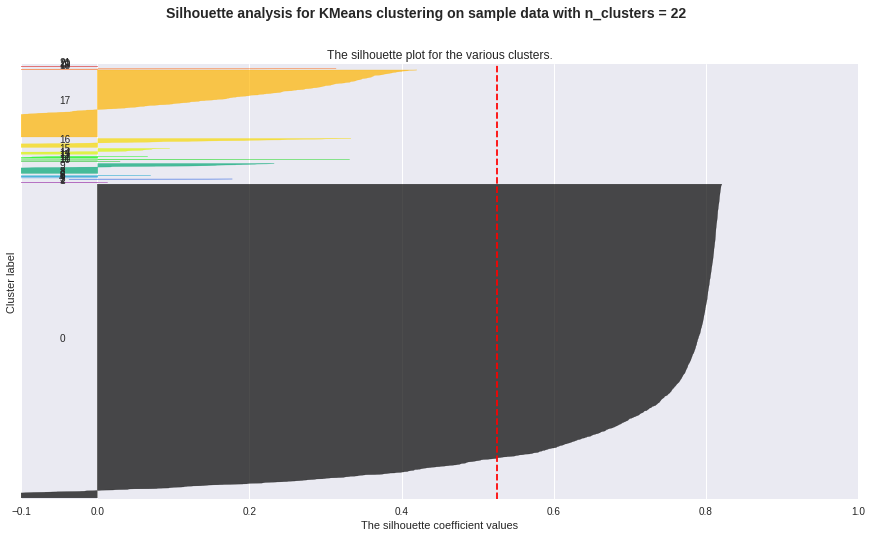

[3316    1    4    1    1    3    2   15    1  106    1    3   11   21    1
   62   95  709    8    1    3    1]
For n_clusters = 23 The average silhouette_score is : 0.499954543499


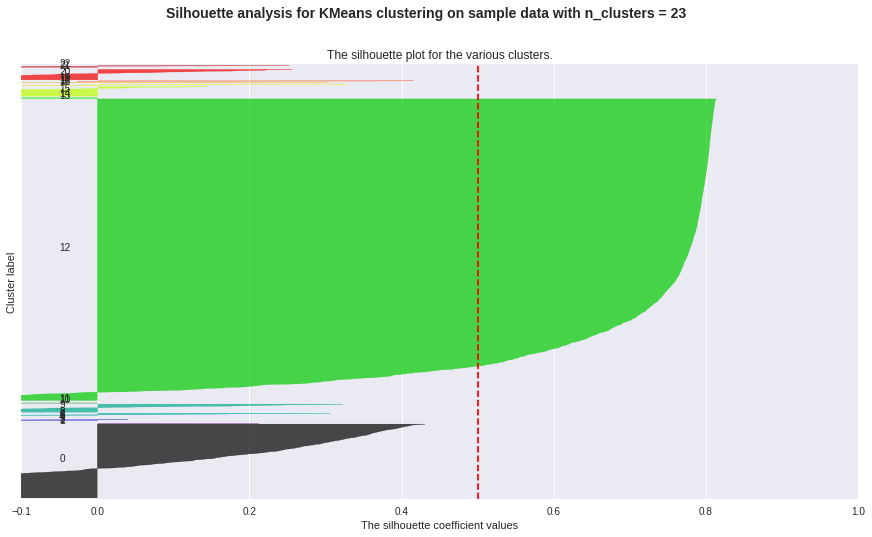

[ 782    2    1    1    9    1    1    1   25   86    2    1 3194    3    2
  101   12    1    2    6  111    1   21]
For n_clusters = 24 The average silhouette_score is : 0.45778804069


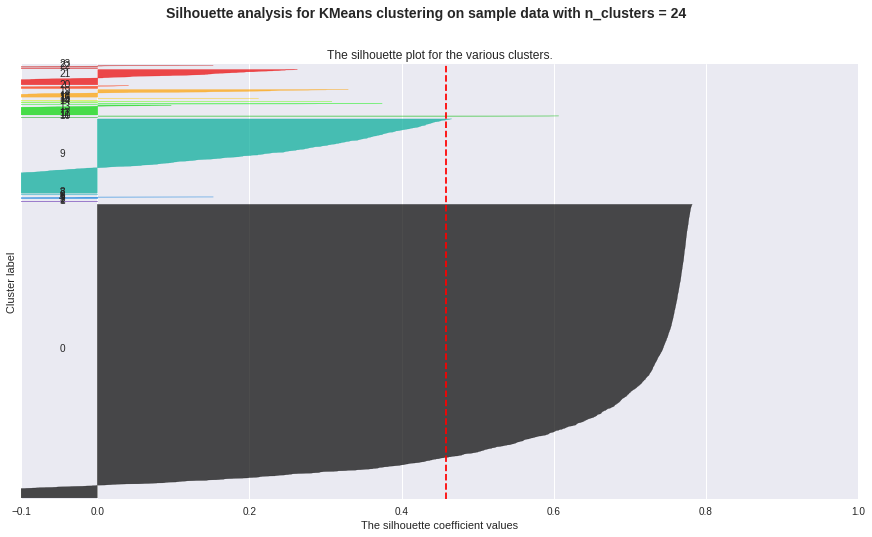

[3116    1    1    2    1    1   18    1    3  789    1    2    4  104    7
   12    3    1    2   81   30  163    3   20]
For n_clusters = 25 The average silhouette_score is : 0.425751584954


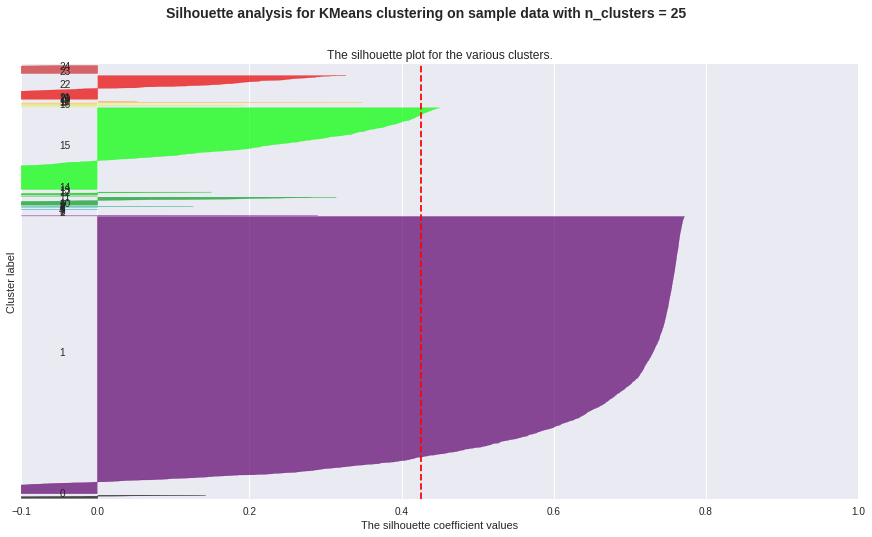

[  34 2950    5    1    1    1    1    1    2    1   12   86    3   31    1
  871    1    8    2   10    2    1  253    1   87]
For n_clusters = 26 The average silhouette_score is : 0.492891085564


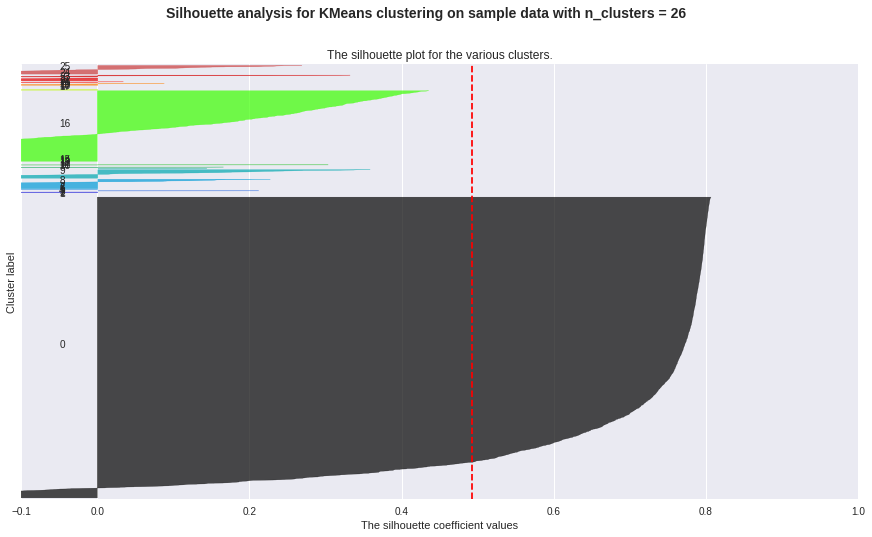

[3207    1    1    1    1    6    2    2  102   92    2    6    1    2    1
    1  753    9    1    1    1   20    8   31   21   93]
For n_clusters = 27 The average silhouette_score is : 0.3892583716


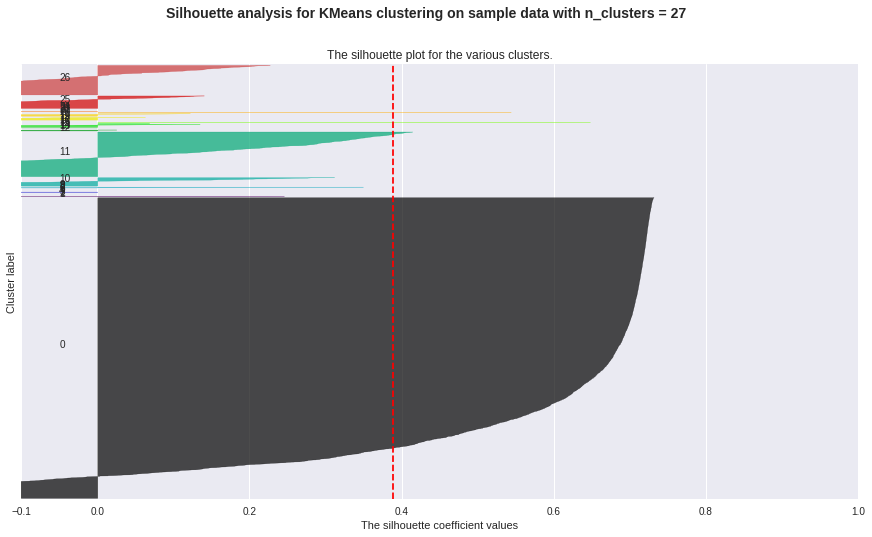

[3213    5    1    1    1    2    1    1    1   10   91  478   11    1    3
   26    2    2    1   32   27    2    2    1    1  134  316]
For n_clusters = 28 The average silhouette_score is : 0.503117211852


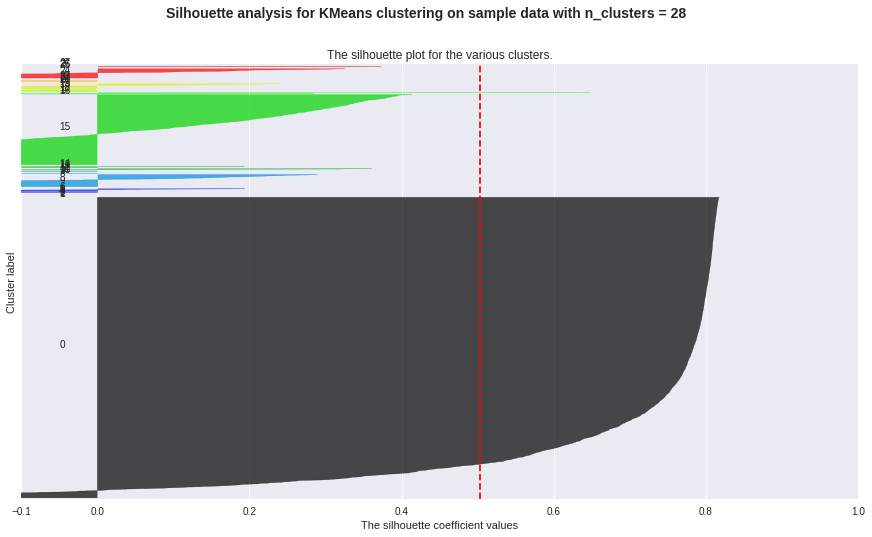

[3219    1    1    1    1    2   31    1  132    2    1    3   16    3    3
  752    7    2   15   58    1    5    2    1  101    1    3    1]
For n_clusters = 29 The average silhouette_score is : 0.450018558591


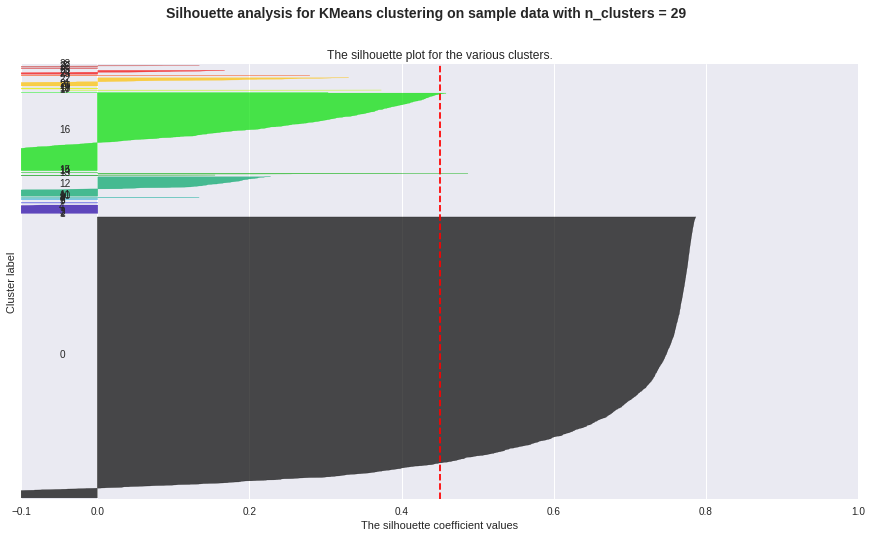

[3015    1    1    1   90    1    3    1    1    2    2    4  209    9    8
    3  833    2    1    5   12    1   88    1    7   42    1    2   20]


In [65]:

for n_clusters in range(20, 30): 
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    kmeans.inertia_
    clusters_stats(n_clusters, clusters, print_words=False)

In [66]:
n_clusters = 24
kmeans = KMeans(init='k-means++', n_clusters=n_clusters)
kmeans.fit(scaled_matrix)
clusters = kmeans.predict(scaled_matrix)
kmeans.inertia_
customers_df = pd.DataFrame(customers)
customers_df['cluster'] = clusters
customers_df.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster
CustomerID,,,,,,,,
12347.00,2410.36,920.50,57.90,459.70,183.54,278.00,0.00,14
12348.00,737.96,884.32,41.76,0.00,69.60,63.60,0.00,14
12349.00,1152.25,417.65,0.00,13.20,154.65,19.80,0.00,6
12350.00,156.20,117.60,40.20,20.40,0.00,0.00,0.00,6
12352.00,1053.81,262.15,32.40,0.00,93.80,103.25,0.00,14


In [67]:
cluster_meta = customers_df.groupby('cluster').agg('mean')
cluster_meta.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6
cluster,,,,,,,
0,2751.90,867.36,330.17,354.52,225.95,159.98,36.92
1,36302.88,14627.88,318.96,3553.08,177.60,3627.81,713.25
2,134620.60,60218.14,3566.08,1074.00,42219.44,468.42,14271.81
3,123109.89,76790.16,6513.83,46967.28,17578.01,8414.20,115.65
4,101841.99,24309.98,2948.04,0.00,50530.34,4921.78,2770.04


In [68]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

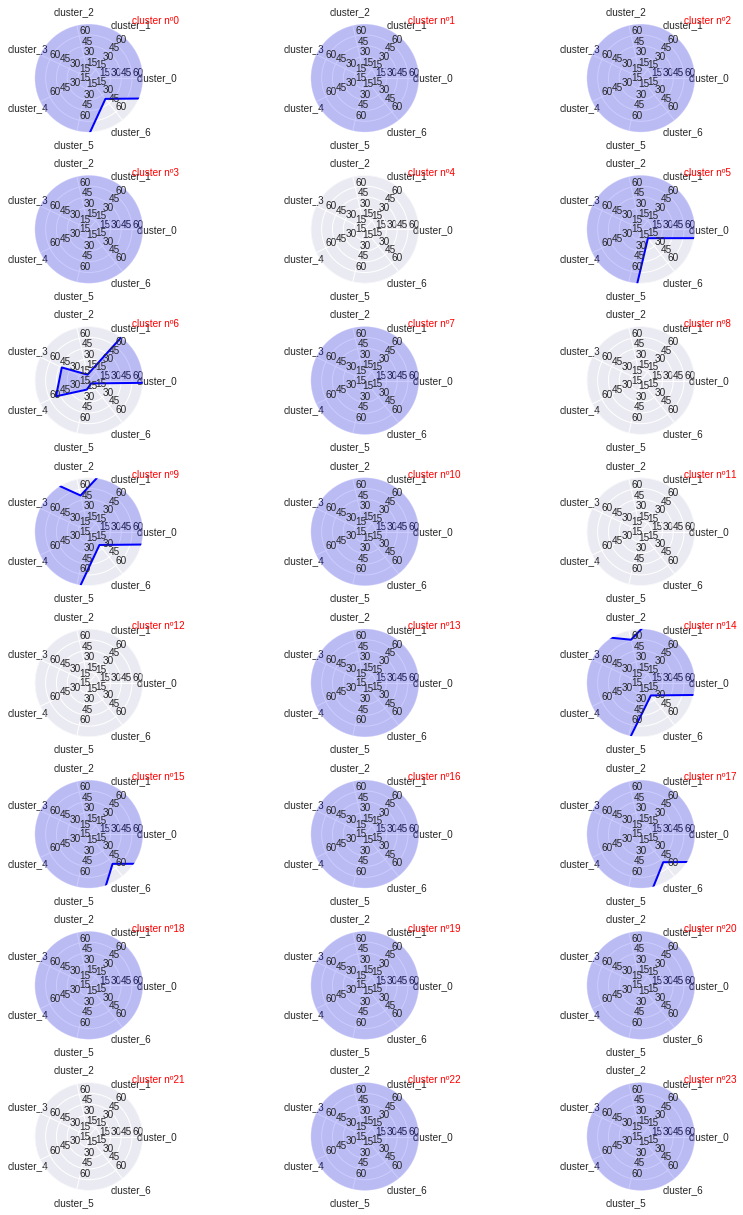

In [71]:
fig = plt.figure(figsize=(10,12))

attributes = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6']
ranges = [[0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = range(30)

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1./i_cols), (1./i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    data = np.array(cluster_meta.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = u'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

# MCL
https://micans.org/mcl/

In [7]:
def to_set(x):
    return set(x)

def to_set_len(x):
    return len(set(x))

product_orders = df.dropna(subset = ['CustomerID'])[['StockCode', 'CustomerID']].groupby('CustomerID', as_index=False).agg([to_set, to_set_len]).reset_index()

In [8]:
product_orders.columns = ['.'.join(filter(None, pair)) for pair in zip(product_orders.columns.get_level_values(0), product_orders.columns.get_level_values(1))]
product_orders.head()

,CustomerID,StockCode.to_set,StockCode.to_set_len
0,12346.00,{23166},1
1,12347.00,"{22775, 22774, 22773, 22772, 22771, 22372, 223...",103
2,12348.00,"{21967, 84992, 84991, 22437, 21211, 21213, 229...",22
3,12349.00,"{23460, 20914, 23108, 37500, 22567, 21231, 217...",73
4,12350.00,"{21866, 21908, 21864, 79066K, 22348, 22620, 22...",17


In [9]:
l = len(product_orders[product_orders['StockCode.to_set_len'] > 0])
l*(l-1)/2.

9555006.0

In [10]:
product_orders_dict = dict(zip(product_orders.CustomerID, product_orders['StockCode.to_set']))

In [11]:
from itertools import combinations
user_pairs = list(combinations(sorted(product_orders_dict.keys()), 2))

In [12]:
user_pairs[:10]

[(12346.0, 12347.0),
 (12346.0, 12348.0),
 (12346.0, 12349.0),
 (12346.0, 12350.0),
 (12346.0, 12352.0),
 (12346.0, 12353.0),
 (12346.0, 12354.0),
 (12346.0, 12355.0),
 (12346.0, 12356.0),
 (12346.0, 12357.0)]

In [13]:
def jaccard(s1, s2):
    return len(s1 & s2) * 1. / len(s1 | s2)

In [19]:
similarities = []
for i1, i2 in user_pairs:
    j = jaccard(product_orders_dict[i1], product_orders_dict[i2])
    if j > 0:
        similarities.append((i1, i2, j))

In [20]:
len(similarities)

5082856

In [21]:
with open('similarities.txt', 'w') as f:
    for u1, u2, s in similarities:
        f.write('{}\t{}\t{}\n'.format(u1, u2, s))

In [ ]:
!/home/stroykova/local/mcl/bin/mcl similarities.txt --abc -o  clusters -I 2 -p 0.0015 -pct 60

In [22]:
!wc -l clusters

33 clusters
